In [152]:
import pandas as pd
import os
from matplotlib import pyplot as plt

folder = "experiments/"

paths = os.listdir(folder)
survey_paths = {path.split("_")[1] : path for path in paths if "survey" in path}
experiment_results_paths = {path.split("_")[1].split('.')[0] : path for path in paths if not "survey" in path}
experiment_ids = list(experiment_results_paths.keys())

print(survey_paths)

{'1651173731': 'comp1_1651173731_survey.csv', '1651174140': 'comp1_1651174140_survey.csv', '1651174244': 'comp1_1651174244_survey.csv', '1651174316': 'comp1_1651174316_survey.csv', '1651174376': 'comp1_1651174376_survey.csv', '1651174477': 'comp1_1651174477_survey.csv', '1651176011': 'comp1_1651176011_survey.csv', '1651176322': 'comp1_1651176322_survey.csv', '1651176556': 'comp1_1651176556_survey.csv', '1651176896': 'comp1_1651176896_survey.csv', '1651177208': 'comp1_1651177208_survey.csv', '1651177349': 'comp1_1651177349_survey.csv', '1651177412': 'comp1_1651177412_survey.csv', '1651177469': 'comp1_1651177469_survey.csv', '1651177572': 'comp1_1651177572_survey.csv', '1651177648': 'comp1_1651177648_survey.csv', '1651177694': 'comp1_1651177694_survey.csv', '1651177751': 'comp1_1651177751_survey.csv', '1651177890': 'comp1_1651177890_survey.csv', '1651178138': 'comp1_1651178138_survey.csv', '1651178210': 'comp1_1651178210_survey.csv', '1651178312': 'comp1_1651178312_survey.csv', '16511783

In [153]:
# Put all surveys and results into separate dictionaries
surveys = {}
results = {}
for id in experiment_ids:
    survey = None
    if id in survey_paths:
        survey_path = survey_paths[id]
        df_survey = pd.read_csv('experiments/' + survey_path)
        surveys.update({id : df_survey})
    if id in experiment_ids:
        results_path = experiment_results_paths[id]
        df_results = pd.read_csv('experiments/' + results_path)

        # Add a new column for time between circle clicks
        df_results['shifted_time'] = df_results['time_clicked'].transform(lambda x: x.shift(periods=1, fill_value=0))
        shift_time = lambda x: x.time_clicked - x.shifted_time
        df_results['delta_t'] = df_results.apply(shift_time, axis=1)
        df_results = df_results.drop('shifted_time', axis=1)

        
        results.update({id : df_results})


In [154]:
old_backup = """
### Analysis of results first (then do surveys)

## Do some cleaning of dfs

for id in results.keys():
    # Drop unnamed column

    # TODO Make the time between clicks about differences NOT about position of t

    # TODO compute accuracy % based on distance from radius of circle (if x <= r, 100%; if x > r, r/x)
    f = lambda x: x.circle_radius/x.click_distance_from_circle_center
    results[id]['accuracy'] = results[id].apply(f, axis=1)



## Combine all dfs into one df
all_results_df = pd.concat(results)
all_results_df = all_results_df.drop('Unnamed: 0', axis=1)
print(all_results_df)
"""

In [155]:
### Analysis of results first (then do surveys)

## Combine all dfs into one df
all_results_df = pd.concat(results)

## Do some cleaning of dfs

# Drop unnamed column and problematic entries
all_results_df = all_results_df.drop('Unnamed: 0', axis=1)
all_results_df = all_results_df.drop(('1651174316', 10))

# TODO Make the time between clicks about differences NOT about position of t
#all_results_df[['shifted_time']] = all_results_df[['time_clicked']].transform(lambda x: x.shift(periods=1, fill_value=0))
#shift_time = lambda x: x.time_clicked - x.shifted_time
#all_results_df[['delta_t']] = all_results_df.apply(shift_time, axis=1)
#all_results_df = all_results_df.drop('shifted_time', axis=1)

# TODO compute accuracy % based on distance from radius of circle (if x <= r, 100%; if x > r, r/x)
f = lambda x: (lambda r, c: 1 if r >= c else r/c)(float(x.circle_radius), float(x.click_distance_from_circle_center))
all_results_df[['accuracy']] = all_results_df.apply(f, axis=1)


# Rename "time_clicked" to t
all_results_df[['t']] = all_results_df[['time_clicked']]
all_results_df = all_results_df.drop('time_clicked', axis=1)
all_results_df[['delta_t', "t"]].head(20)

delta_t         t
1651173731 0  1.486618  1.486618
           1  1.484163  2.970781
           2  1.149053  4.119834
           3  1.066986  5.186820
           4  0.773116  5.959936
           5  1.089438  7.049374
           6  0.538733  7.588107
           7  0.355132  7.943239
           8  0.694108  8.637347
           9  0.990430  9.627777
1651174140 0  2.074000  2.074000
           1  1.285695  3.359695
           2  0.891973  4.251669
           3  0.430565  4.682234
           4  0.619025  5.301260
           5  0.734981  6.036240
           6  0.636026  6.672266
           7  0.498812  7.171078
           8  0.596253  7.767331
           9  0.566000  8.333331

DPI SETTING 1
dpi_setting    1.000000
accuracy       0.988104
delta_t        0.942453
dtype: float64

DPI SETTING 2
dpi_setting    2.000000
accuracy       0.955055
delta_t        0.806196
dtype: float64

DPI SETTING 3
dpi_setting    3.000000
accuracy       0.901893
delta_t        0.765532
dtype: float64



[Text(0, -18, '98.8%'), Text(0, -18, '95.5%'), Text(0, -18, '90.2%')]

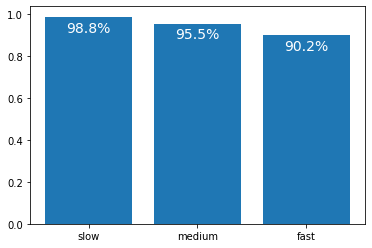

In [175]:
# Accuracy readout for all dpi settings
accuracies = []
times = []
for i in [1, 2, 3]:
    columns = ['dpi_setting', 'accuracy', 'delta_t']
    print(f"DPI SETTING {i}")
    dpi_mean_results = all_results_df[columns].query(f"dpi_setting == {i}").mean()
    print(dpi_mean_results)
    print()
    accuracies.append(dpi_mean_results["accuracy"])
    times.append(dpi_mean_results["delta_t"])

# Plot info
dpis = ["slow", "medium", "fast"]

accuracy_labels = [f"{x*100:0.1f}%" for x in accuracies]
accuracy_bar = plt.bar(dpis, accuracies)
plt.bar_label(accuracy_bar, padding=-18, color='w', fontsize=14, labels=accuracy_labels)
